# Molecular dynamics simulations with OpenMM
[OpenMM](http://openmm.org/) is software library for performing molecular dynamics simulations. It is designed to be flexible and efficient and it focuses on simulations of biomolecules. OpenMM is written in C++ and CUDA and has Python bindings, which makes it easy to use in Python scripts. In this example, we will show how to set up molecular dynamics simulations using OpenMM.

In [1]:
import openmm as mm
import openmm.app as app
import openmm.unit as unit
import numpy as np
import nglview as nv
import mdtraj
import polars as pl
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-talk")

## 1. A 1-D harmonic oscillator
We will start with a simple example of a 1-D harmonic oscillator. In the example, we have a particle of mass 1 amu that is connected to a fixed point by a spring. The particle is constrained to move along the x-axis. The spring has a force constant of 1 kJ/mol/nm^2. The equilibrium position of the particle is at (0, 0, 0), which means the force is zero when the particle is at the origin.

OpenMM uses a class called `System` to represent the system that we want to simulate. The `System` class contains a list of particles and a list of forces acting on those particles. To simulate the 1-D harmonic oscillator described above, we need to create a `System` object for it.

In [2]:
## initialize an empty system
system = mm.System()

## add two particles to the system, the first one will be fixed at (0, 0, 0) and the second one
## will be free to move in the x axis. The two particles will be connected by a spring

## add the first particle with mass 0 amu
## OpenMM has a special setting that massless particles are fixed
system.addParticle(0 * unit.amu)

## add the second particle with mass 1 amu
system.addParticle(1 * unit.amu)

print("Number of particles in the system: ", system.getNumParticles())

Number of particles in the system:  2


- To model the spring between the two particles, we will add a force between the two particles. The force is given by Hooke's law: $f = -kx$, where $k$ is the force constant and $x$ is the displacement from the equilibrium position. The potential energy corresponding to this force is given by $V = \frac{1}{2}kx^2$, which is called the harmonic potential. As a rule of thumb, it is usually easier to specify the potential energy function rather than the force function.

- OpenMM has a built-in class called `HarmonicBondForce` for harmonic potentials.

In [3]:
## initialize a HarmonicBondForce
harmonic_force = mm.HarmonicBondForce()

## specify that the force is between the particles with index 0 and 1.
## the index of a particle is the order in which it was added to the system and starts at 0
## because the first particle will be fixed at (0, 0, 0), we set the equilibrium distance to 0 nm
## so that the equilibrium position of the second particle is at (0, 0, 0)
harmonic_force.addBond(
    0, 1, 0.0 * unit.nanometer, 1 * unit.kilojoule_per_mole / unit.nanometer**2
)

## add the force to the system
system.addForce(harmonic_force)

0

In OpenMM, each particle has three coordinates $(x, y, z)$. To mimic the constraint of the second particle along the x-axis, we add a large external force on the second particle in the y and z directions. This force is large enough to keep the second particle from moving in the y and z directions. We use [`CustomExternalForce`](http://docs.openmm.org/latest/api-python/generated/openmm.openmm.CustomExternalForce.html#openmm.openmm.CustomExternalForce) in OpenMM to apply this force. The `CustomExternalForce` class allows us to specify a custom force function that can depend on the coordinates of the particles. In this case, we will use a harmonic potential in the y and z directions with a large force constant and the equilibrium position at 0.0. This will create a large force on the second particle in the y and z directions if it moves away from 0 in those directions. It effectively constrains the second particle to move only in the x direction.

In [4]:
k_external = 100
external_force = mm.CustomExternalForce("0.5*k_external*(y^2 + z^2)")
external_force.addGlobalParameter("k_external", k_external)
external_force.addParticle(1, [])

system.addForce(external_force)

1

- To simulate the system, we need to specify the integrator used to integrate the equations of motion. OpenMM has several built-in integrators, including `LangevinIntegrator`, `VerletIntegrator`, and `BrownianIntegrator`. In this example, we will first use the `VerletIntegrator` to integrate the Hamiltonian equations of motion.

- In addition, we also need to specify the kind of hardware we are using to run the simulation. OpenMM can run on a CPU or a GPU and it uses the class `Platform` to specify the hardware. In this example, we will use the `CPU` platform to run the simulation on the CPU.

- There is one more thing we need to do before we can run the simulation in OpenMM. OpenMM uses a class called [Context](http://docs.openmm.org/latest/api-python/generated/openmm.openmm.Context.html#openmm.openmm.Context) to represent the complete state of a simulation and a `Context` object is created from a `System` object, an `Integrator` object, and a `Platform` object. The `Context` object contains among other things the positions and velocities of all the particles in the system. Before running the simulation, we also need to set the initial positions and velocities of the particles in the context.

In [10]:
## create an integrator with a time step of 0.1 ps
## you could change the size of the time step to see how it affects the simulation
step_size = 0.1
integrator = mm.VerletIntegrator(step_size * unit.picoseconds)

## pick a platform
## in this case we will use the CPU platform
## if you want to use NVIDIA GPU, you could use "CUDA" instead
platform = mm.Platform.getPlatformByName("CPU")

## create a context
context = mm.Context(system, integrator, platform)


## set the initial positions of the particles
init_x = np.array(
    [
        [0.0, 0.0, 0.0],  # particle 0
        [0.0, 0.0, 0.0],  # particle 1
    ]
)

context.setPositions(init_x)

## set the initial velocities of the particles
init_v = np.array(
    [
        [0.0, 0.0, 0.0],  # particle 0
        [1.0, 0.0, 0.0],  # particle 1
    ]
)

context.setVelocities(init_v)

## because the initial velocity of the second particle is (1, 0, 0) and its initial position
## is at the equilibrium position of the spring, the total energy of the second particle is
## 0.5 * m * v^2 = 0.5 * 1 * 1^2 = 0.5

Now we are ready to run the simulation. To take a time step in the simulation, we call the `step` method of the integrator. After taking a time step, we record the new positions and velocities of the particles from the context.

In [11]:
xs = []  # positions
vs = []  # velocities
us = []  # potential energy
ks = []  # kinetic energy
es = []  # total energy

for i in range(50):
    integrator.step(1)

    state = context.getState(getEnergy=True, getPositions=True, getVelocities=True)
    x = state.getPositions(asNumpy=True).value_in_unit(unit.nanometer)
    v = state.getVelocities(asNumpy=True).value_in_unit(
        unit.nanometer / unit.picosecond
    )
    u = state.getPotentialEnergy().value_in_unit(unit.kilojoule_per_mole)
    k = state.getKineticEnergy().value_in_unit(unit.kilojoule_per_mole)

    xs.append(x)
    vs.append(v)
    us.append(u)
    ks.append(k)
    es.append(u + k)

    print(
        f"step: {i + 1:3d};  u: {u:6.3f}; x: {x[1][0]:6.3f}; k: {k:6.3f}; v: {v[1][0]:6.3f}; e: {u + k:6.3f}"
    )

xs = np.array(xs)
vs = np.array(vs)
us = np.array(us)
ks = np.array(ks)

step:   1;  u:  0.005; x:  0.100; k:  0.495; v:  1.000; e:  0.500
step:   2;  u:  0.020; x:  0.199; k:  0.480; v:  0.990; e:  0.500
step:   3;  u:  0.044; x:  0.296; k:  0.456; v:  0.970; e:  0.500
step:   4;  u:  0.076; x:  0.390; k:  0.424; v:  0.940; e:  0.500
step:   5;  u:  0.115; x:  0.480; k:  0.385; v:  0.901; e:  0.500
step:   6;  u:  0.160; x:  0.566; k:  0.340; v:  0.853; e:  0.500
step:   7;  u:  0.208; x:  0.645; k:  0.292; v:  0.797; e:  0.501
step:   8;  u:  0.258; x:  0.718; k:  0.243; v:  0.732; e:  0.501
step:   9;  u:  0.308; x:  0.785; k:  0.193; v:  0.661; e:  0.501
step:  10;  u:  0.355; x:  0.843; k:  0.146; v:  0.582; e:  0.501
step:  11;  u:  0.398; x:  0.893; k:  0.103; v:  0.498; e:  0.501
step:  12;  u:  0.436; x:  0.933; k:  0.065; v:  0.409; e:  0.501
step:  13;  u:  0.466; x:  0.965; k:  0.036; v:  0.315; e:  0.501
step:  14;  u:  0.487; x:  0.987; k:  0.014; v:  0.219; e:  0.501
step:  15;  u:  0.499; x:  0.999; k:  0.002; v:  0.120; e:  0.501
step:  16;

### Visualize results of OpenMM simuation

- Plot the numerical trajectory in the phase space of $(x, p_x)$ where x is the x-coordinate of the particle and p_x is the x-component of the momentum of the particle. The numerical trajectory is compared to the analytical trajectory. You could change the step size used in the integrator to see how it affects the accuracy of the numerical trajectory.

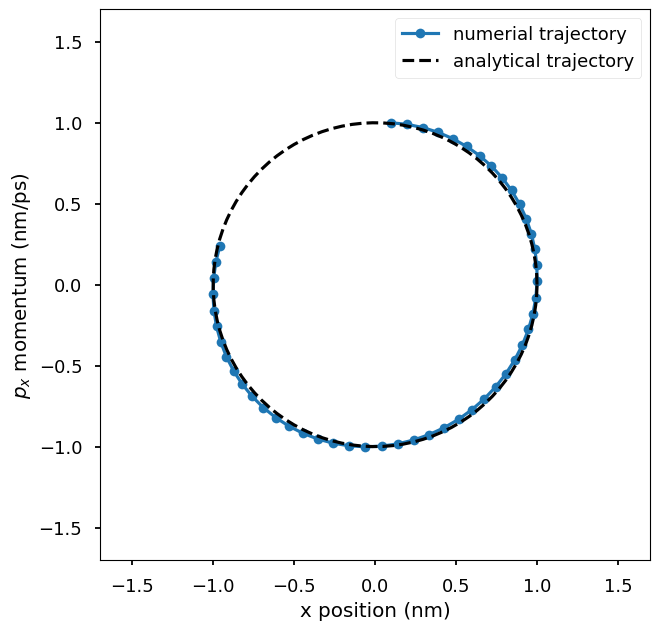

In [12]:
ps = vs  ## momentum
plt.plot(xs[:, 1, 0], ps[:, 1, 0], "o-", label="numerial trajectory", markersize=7)
plt.plot(
    np.cos(np.linspace(0, 2 * np.pi, 100)),
    np.sin(np.linspace(0, 2 * np.pi, 100)),
    "k--",
    label="analytical trajectory",
)
plt.xlim(-1.7, 1.7)
plt.ylim(-1.7, 1.7)
plt.xlabel("x position (nm)")
plt.ylabel(r"$p_x$ momentum (nm/ps)")
plt.legend()
plt.gca().set_aspect("equal", adjustable="box")

- Plot the potential energy and kinetic energy of the particle as a function of time. The Hamiltonian equation of motion is energy conserving, so the total energy of the system is close to a constant. The small oscillations in the total energy are due to numerical errors in the integration. The kinetic energy and potential energy oscillate in time. Because the Hamiltonian equations is energy conserving, conformations sampled by integrating the Hamiltonian equations are the ones from the system's NVE ensemble.

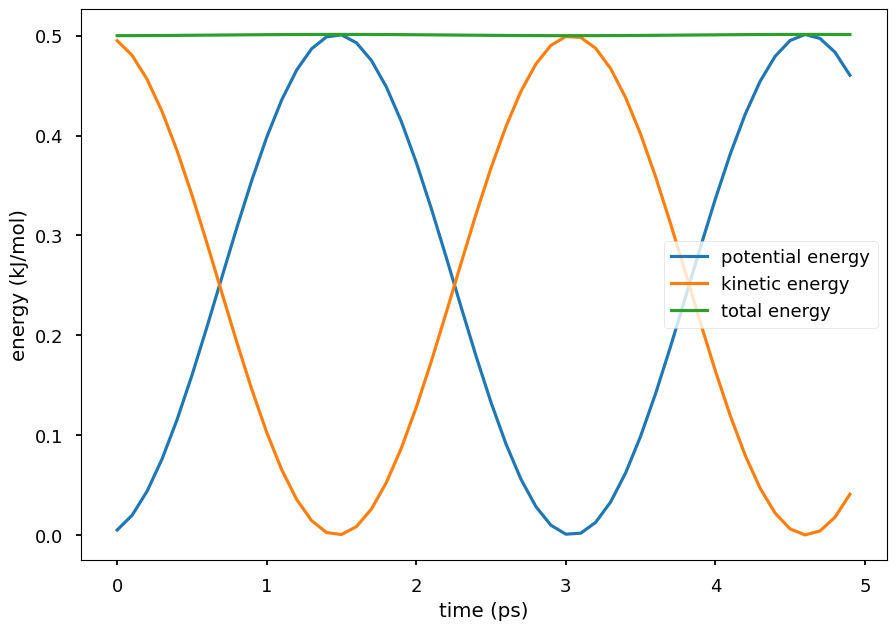

In [13]:
plt.plot(np.arange(len(us)) * step_size, us, label="potential energy")
plt.plot(np.arange(len(ks)) * step_size, ks, label="kinetic energy")
plt.plot(np.arange(len(us)) * step_size, us + ks, label="total energy")
plt.xlabel("time (ps)")
plt.ylabel("energy (kJ/mol)")
plt.legend()
plt.show()

- To sample from the NVT ensemble, we can use the `LangevinIntegrator` instead of the `VerletIntegrator`. The Langevin integrator integrates the Langevin equations of motion, which mathematically models the effect of a heat bath on the system. 

In [30]:
## construct a Langevin integrator at temperature T
T = 300
integrator = mm.LangevinIntegrator(
    T * unit.kelvin,  # temperature
    1 / unit.picosecond,  # friction coefficient
    step_size * unit.picoseconds,  # time step
)

platform = mm.Platform.getPlatformByName("CPU")

context = mm.Context(system, integrator, platform)
context.setPositions(init_x)
context.setVelocitiesToTemperature(T)

xs = []  # positions
vs = []  # velocities
us = []  # potential energy
ks = []  # kinetic energy
es = []  # total energy

for i in range(5000):
    integrator.step(1)

    state = context.getState(getEnergy=True, getPositions=True, getVelocities=True)
    x = state.getPositions(asNumpy=True).value_in_unit(unit.nanometer)
    v = state.getVelocities(asNumpy=True).value_in_unit(
        unit.nanometer / unit.picosecond
    )
    u = state.getPotentialEnergy().value_in_unit(unit.kilojoule_per_mole)
    k = state.getKineticEnergy().value_in_unit(unit.kilojoule_per_mole)

    xs.append(x)
    vs.append(v)
    us.append(u)
    ks.append(k)
    es.append(u + k)

    if (i + 1) % 100 == 0:
        print(
            f"step: {i + 1:3d};  u: {u:6.3f}; x: {x[1][0]:6.3f}; k: {k:6.3f}; v: {v[1][0]:6.3f}; e: {u + k:6.3f}"
        )

xs = np.array(xs)
vs = np.array(vs)
us = np.array(us)
ks = np.array(ks)
ps = vs  ## momentum

step: 100;  u:  3.136; x:  1.143; k:  4.316; v: -1.446; e:  7.452
step: 200;  u:  5.647; x: -0.147; k:  2.820; v:  1.977; e:  8.467
step: 300;  u:  0.340; x:  0.822; k:  2.614; v: -1.473; e:  2.954
step: 400;  u:  4.014; x:  2.009; k:  2.485; v: -1.167; e:  6.499
step: 500;  u:  5.025; x:  1.706; k:  2.618; v: -1.262; e:  7.644
step: 600;  u:  6.007; x: -2.908; k: 10.900; v: -0.102; e: 16.907
step: 700;  u:  6.871; x: -2.736; k:  1.911; v: -1.451; e:  8.782
step: 800;  u:  5.153; x: -0.937; k:  0.569; v: -1.015; e:  5.722
step: 900;  u: 11.561; x: -3.538; k:  2.376; v:  0.843; e: 13.937
step: 1000;  u:  3.798; x:  0.118; k:  0.044; v: -0.211; e:  3.842
step: 1100;  u:  1.162; x: -0.731; k:  1.781; v: -1.721; e:  2.943
step: 1200;  u:  3.194; x: -0.520; k:  2.819; v: -0.149; e:  6.013
step: 1300;  u:  2.521; x:  0.717; k:  0.610; v: -0.550; e:  3.130
step: 1400;  u:  0.744; x:  1.014; k:  9.965; v:  2.138; e: 10.709
step: 1500;  u:  5.642; x:  0.674; k:  6.134; v:  2.863; e: 11.776
step

- Plot $(x, p_x)$ for the second particle. The first plot shows the numerical trajectory in the first 50 steps. Because the Langevin integrator is a stochastic integrator, the trajectory is stochastic. The second plot shows more $(x, p_x)$ points from the trajectory. In the second plot, a pattern emerges. Those points of $(x, p_x)$ are distributed according to a 2-d Gaussian distribution, which is the Boltzmann distribution at temperature T, i.e., $p(x, p_x)$ is proportional to $\exp(-E(x, p_x)/k_BT)$ where $E(x, p_x) = U(x) + K(p_x) = 1/2kx^2 + 1/2mv^2 = 1/2x^2 + 1/2p_x^2$. The Boltzmann distribution of the system is a 2-d Gaussian distribution with mean $(0, 0)$ and variance $(k_BT, k_BT)$.

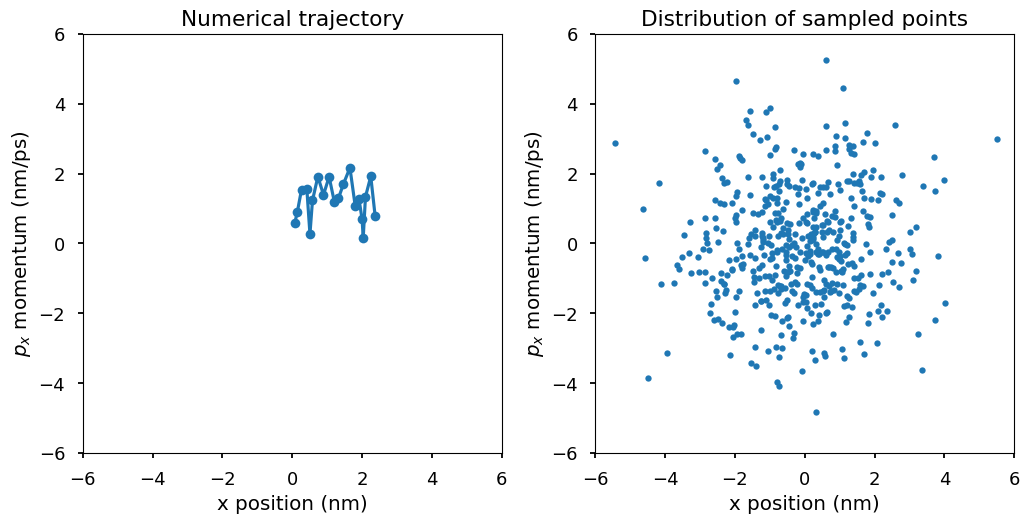

In [31]:
plt.subplot(1, 2, 1)
plt.plot(xs[:20, 1, 0], ps[:20, 1, 0], "o-", markersize=7)
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.gca().set_aspect("equal", adjustable="box")
plt.xlabel("x position (nm)")
plt.ylabel(r"$p_x$ momentum (nm/ps)")
plt.title("Numerical trajectory")

plt.subplot(1, 2, 2)
plt.plot(xs[::10, 1, 0], ps[::10, 1, 0], ".")
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.xlabel("x position (nm)")
plt.ylabel(r"$p_x$ momentum (nm/ps)")
plt.gca().set_aspect("equal", adjustable="box")
plt.title("Distribution of sampled points")
plt.tight_layout()
plt.show()

- Let compute the mean and variance of the sampled $(x, p_x)$ points and see if they are close to the expected values. 

In [32]:
print(f"mean of x: {np.mean(xs[::10, 1, 0]):.3f}")
print(f"mean of p_x: {np.mean(ps[::10, 1, 0]):.3f}")

print(f"variance of x: {np.var(xs[::10, 1, 0]):.3f}")
print(f"variance of p_x: {np.var(ps[::10, 1, 0]):.3f}")

mean of x: -0.134
mean of p_x: -0.042
variance of x: 2.616
variance of p_x: 2.695


- In the NVT ensemble, the system is in contact with a heat bath at temperature T and therefore the system can exchange energy with the heat bath, which results in the fluctuations in the total energy of the system. 

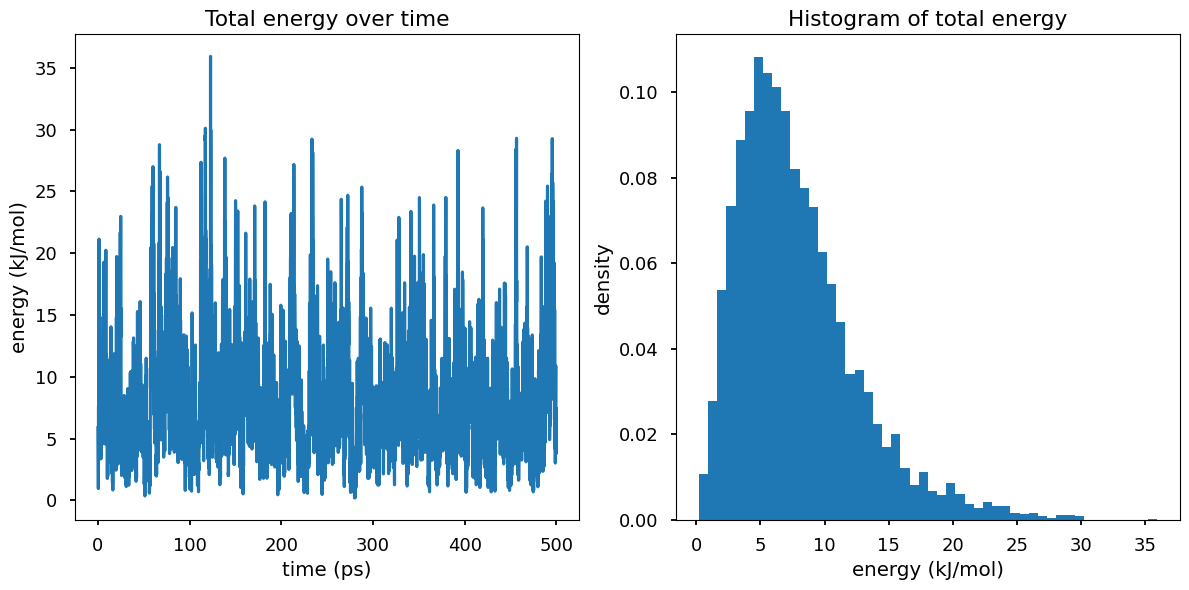

In [33]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(
    np.arange(len(us)) * step_size,
    es,
    label="total energy",
)
plt.xlabel("time (ps)")
plt.ylabel("energy (kJ/mol)")
plt.title("Total energy over time")

plt.subplot(1, 2, 2)
plt.hist(es, bins=50, density=True)
plt.xlabel("energy (kJ/mol)")
plt.ylabel("density")
plt.title("Histogram of total energy")
plt.tight_layout()
plt.show()